In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.decomposition import PCA


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
class Data(Dataset):
    def __init__(self, X, y):
        self.data = torch.from_numpy(X.astype(np.float32))
        self.labels = torch.from_numpy(y.astype(np.float32))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [3]:
n_classes = 10

X, y = make_classification(n_samples=50000,
                           n_classes=n_classes, 
                           n_features=10,
                           n_informative=10,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=15
                          )
y_oh = np.eye(n_classes)[y]
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.50, shuffle=False)
data = Data(X, y_oh)
training_data = Data(X_train, y_train)
test_data = Data(X_test, y_test)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 128)
        self.fc2 = nn.Linear(128, 128)
        #self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(128, 10)
        
        self.dropout1 = nn.Dropout(0.2)
        #self.dropout2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout1(x)
        #x = self.fc3(x)
        #x = F.relu(x)
        #x = self.dropout2(x)
        logits = self.fc4(x)
        return logits

In [6]:
def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return 100*correct, test_loss

In [8]:
def display_losses(model, X_2d, training_data, test_data, loss_fn, epoch):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    model.eval()

    loss = []
    for x, y in training_data:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss.append(loss_fn(pred, y).item())

    loss = np.array(loss)

    ax.scatter(X_2d[:512, 0], X_2d[:512, 1], loss[:], marker='x', alpha=0.6)

    loss = []
    for x, y in test_data:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss.append(loss_fn(pred, y).item())

    loss = np.array(loss)

    ax.scatter(X_2d[512:, 0], X_2d[512:, 1], loss[:], marker='.', alpha=0.6)

    ax.view_init(elev=5,azim=30)
    ax.set_zlim(0,4.0)
    plt.savefig(f"individual_loss_{epoch}.png")
    #plt.show()
    plt.close()

In [9]:
def display_classification_probabilities(model, data, epoch):
    model.eval()
    with torch.no_grad():
        pred_t = F.softmax(model(data[5864][0].to(device)), dim=0).to("cpu").numpy()
        pred_o = F.softmax(model(data[25258][0].to(device)), dim=0).to("cpu").numpy()
    fig = plt.figure(figsize=(10,5))
    plt.bar(np.arange(10), pred_t)
    plt.ylim(0,1)
    plt.savefig(f"training_data_proba_{epoch}.png")
    plt.close()
    
#     fig = plt.figure(figsize=(10,5))
#     plt.bar(np.arange(10), pred_o)
#     plt.ylim(0,1)
#     plt.savefig(f"testing_data_proba_{epoch}.png")
#     plt.close()
    #plt.show()

In [10]:
model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

NeuralNetwork(
  (fc1): Linear(in_features=10, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)


In [11]:
epochs = 100
train_accs = []
train_losses = []
test_accs = []
test_losses = []

train_acc, train_loss = test(train_dataloader, model, loss_fn)
test_acc, test_loss = test(test_dataloader, model, loss_fn)
train_accs.append(train_acc)
train_losses.append(train_loss)
test_accs.append(test_acc)
test_losses.append(test_loss)
#display_losses(model, X_2d, training_data, test_data, loss_fn, 0)
display_classification_probabilities(model, data, 0)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, scheduler)
    train_acc, train_loss = test(train_dataloader, model, loss_fn)
    test_acc, test_loss = test(test_dataloader, model, loss_fn)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    #display_losses(model, X_2d, training_data, test_data, loss_fn, t+1)
    display_classification_probabilities(model, data, t+1)
print("Done!")

Epoch 1
-------------------------------


Epoch 2
-------------------------------


Epoch 3
-------------------------------


Epoch 4
-------------------------------


Epoch 5
-------------------------------


Epoch 6
-------------------------------


Epoch 7
-------------------------------


Epoch 8
-------------------------------


Epoch 9
-------------------------------


Epoch 10
-------------------------------


Epoch 11
-------------------------------


Epoch 12
-------------------------------


Epoch 13
-------------------------------


Epoch 14
-------------------------------


Epoch 15
-------------------------------


Epoch 16
-------------------------------


Epoch 17
-------------------------------


Epoch 18
-------------------------------


Epoch 19
-------------------------------


Epoch 20
-------------------------------


Epoch 21
-------------------------------


Epoch 22
-------------------------------


Epoch 23
-------------------------------


Epoch 24
-------------------------------


Epoch 25
-------------------------------


Epoch 26
-------------------------------


Epoch 27
-------------------------------


Epoch 28
-------------------------------


Epoch 29
-------------------------------


Epoch 30
-------------------------------


Epoch 31
-------------------------------


Epoch 32
-------------------------------


Epoch 33
-------------------------------


Epoch 34
-------------------------------


Epoch 35
-------------------------------


Epoch 36
-------------------------------


Epoch 37
-------------------------------


Epoch 38
-------------------------------


Epoch 39
-------------------------------


Epoch 40
-------------------------------


Epoch 41
-------------------------------


Epoch 42
-------------------------------


Epoch 43
-------------------------------


Epoch 44
-------------------------------


Epoch 45
-------------------------------


Epoch 46
-------------------------------


Epoch 47
-------------------------------


Epoch 48
-------------------------------


Epoch 49
-------------------------------


Epoch 50
-------------------------------


Epoch 51
-------------------------------


Epoch 52
-------------------------------


Epoch 53
-------------------------------


Epoch 54
-------------------------------


Epoch 55
-------------------------------


Epoch 56
-------------------------------


Epoch 57
-------------------------------


Epoch 58
-------------------------------


Epoch 59
-------------------------------


Epoch 60
-------------------------------


Epoch 61
-------------------------------


Epoch 62
-------------------------------


Epoch 63
-------------------------------


Epoch 64
-------------------------------


Epoch 65
-------------------------------


Epoch 66
-------------------------------


Epoch 67
-------------------------------


Epoch 68
-------------------------------


Epoch 69
-------------------------------


Epoch 70
-------------------------------


Epoch 71
-------------------------------


Epoch 72
-------------------------------


Epoch 73
-------------------------------


Epoch 74
-------------------------------


Epoch 75
-------------------------------


Epoch 76
-------------------------------


Epoch 77
-------------------------------


Epoch 78
-------------------------------


Epoch 79
-------------------------------


Epoch 80
-------------------------------


Epoch 81
-------------------------------


Epoch 82
-------------------------------


Epoch 83
-------------------------------


Epoch 84
-------------------------------


Epoch 85
-------------------------------


Epoch 86
-------------------------------


Epoch 87
-------------------------------


Epoch 88
-------------------------------


Epoch 89
-------------------------------


Epoch 90
-------------------------------


Epoch 91
-------------------------------


Epoch 92
-------------------------------


Epoch 93
-------------------------------


Epoch 94
-------------------------------


Epoch 95
-------------------------------


Epoch 96
-------------------------------


Epoch 97
-------------------------------


Epoch 98
-------------------------------


Epoch 99
-------------------------------


Epoch 100
-------------------------------


Done!


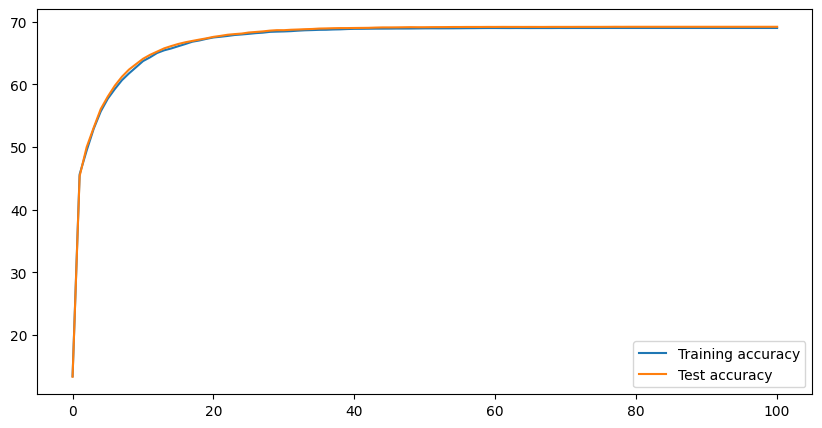

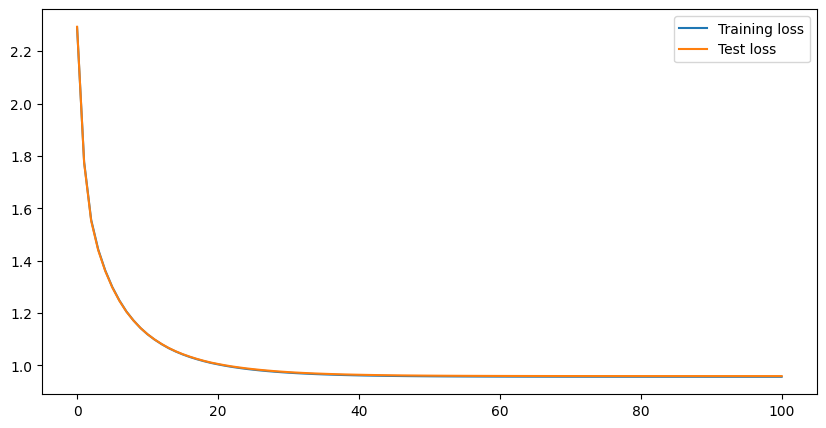

In [12]:
fig = plt.figure(figsize=(10,5))
plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Test accuracy')
plt.legend()
plt.show()
plt.close()

fig = plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()
plt.close()

In [13]:
display(test(train_dataloader, model, loss_fn))
display(test(test_dataloader, model, loss_fn))

(69.0, 0.9564283331641761)

(69.192, 0.9590052040031803)

In [14]:
pred = model(training_data[0][0].to(device))

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (10,).

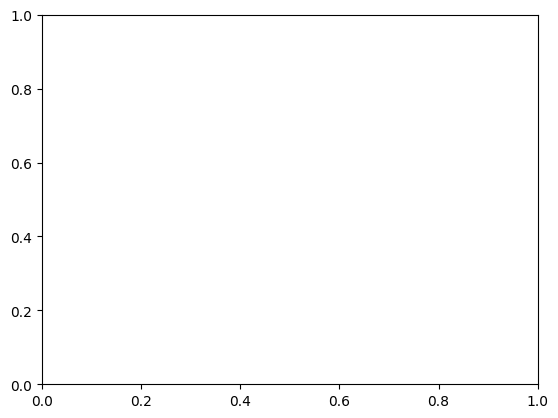

In [15]:
plt.bar([0,1], F.softmax(pred, dim=0).to("cpu").detach())
plt.show()